# Logistic Regression: Titanic

In [30]:
import pandas as pd
import numpy as np
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

import matplotlib.pyplot as plt

## Load Dataset

In [5]:
df = pd.read_csv("data/titanic_modified_dataset.csv", index_col="PassengerId")
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,0
2,1,1,38.0,1,0,71.2833,1,1,1
3,3,1,26.0,0,0,7.9250,0,2,1
4,1,1,35.0,1,0,53.1000,0,1,1
5,3,0,35.0,0,0,8.0500,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int64  
 7   Title     891 non-null    int64  
 8   Survived  891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 69.6 KB


In [7]:
dataset_arr = df.to_numpy().astype(np.float64)
dataset_arr

array([[ 3.,  0., 22., ...,  0.,  0.,  0.],
       [ 1.,  1., 38., ...,  1.,  1.,  1.],
       [ 3.,  1., 26., ...,  0.,  2.,  1.],
       ...,
       [ 3.,  1., 28., ...,  0.,  2.,  0.],
       [ 1.,  0., 26., ...,  1.,  0.,  1.],
       [ 3.,  0., 32., ...,  2.,  0.,  0.]])

In [8]:
X = dataset_arr[:, :-1]
y = dataset_arr[:, -1]

X.shape, y.shape

((891, 8), (891,))

In [9]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)
X_b

array([[ 1.    ,  3.    ,  0.    , ...,  7.25  ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  1.    , ..., 71.2833,  1.    ,  1.    ],
       [ 1.    ,  3.    ,  1.    , ...,  7.925 ,  0.    ,  2.    ],
       ...,
       [ 1.    ,  3.    ,  1.    , ..., 23.45  ,  0.    ,  2.    ],
       [ 1.    ,  1.    ,  0.    , ..., 30.    ,  1.    ,  0.    ],
       [ 1.    ,  3.    ,  0.    , ...,  7.75  ,  2.    ,  0.    ]])

## Train test val split 7:2:1

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_b, y, test_size=0.2, random_state=2, shuffle=True
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 9), (179, 9), (712,), (179,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.125, random_state=2, shuffle=True
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623, 9), (89, 9), (623,), (89,))

## Normalization

In [12]:
normalizer = StandardScaler()

X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

X_train

array([[ 1.        ,  0.8380325 , -0.73366996, ..., -0.34812766,
         0.89679528, -0.55130115],
       [ 1.        , -1.55141486, -0.73366996, ...,  1.76556546,
        -0.60106922, -0.55130115],
       [ 1.        ,  0.8380325 , -0.73366996, ..., -0.47988477,
        -0.60106922, -0.55130115],
       ...,
       [ 1.        ,  0.8380325 , -0.73366996, ..., -0.48238806,
         2.39465977, -0.55130115],
       [ 1.        ,  0.8380325 , -0.73366996, ..., -0.22655193,
        -0.60106922, -0.55130115],
       [ 1.        ,  0.8380325 , -0.73366996, ..., -0.05432564,
         2.39465977,  1.3289577 ]])

## Train & Evaluation

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict(X, theta):
    return sigmoid(np.dot(X, theta))


def compute_loss(y, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()


def compute_gradient(X, y, y_pred):
    return np.dot(X.T, (y_pred - y)) / y.size


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(X, y, theta):
    y_pred = predict(X, theta).round()
    acc = (y_pred == y).mean()
    return acc


In [17]:
lr = 0.01
epochs = 1000
batch_size = 16

np.random.seed(2)
theta = np.random.uniform(size=X_train.shape[1])
theta

array([0.4359949 , 0.02592623, 0.54966248, 0.43532239, 0.4203678 ,
       0.33033482, 0.20464863, 0.61927097, 0.29965467])

In [18]:
train_accs, train_losses = [], []
val_accs, val_losses = [], []

for epoch in range(epochs):
    train_batch_losses, train_batch_accs = [], []
    val_batch_losses, val_batch_accs = [], []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i: i + batch_size]
        y_i = y_train[i: i + batch_size]

        y_pred = predict(X_i, theta)
        train_loss = compute_loss(y_i, y_pred)
        train_batch_losses.append(train_loss)
        gradient = compute_gradient(X_i, y_i, y_pred)
        theta = update_theta(theta, gradient, lr)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)
        
        y_val_pred = predict(X_val, theta)
        val_loss = compute_loss(y_val_pred, y_val)
        val_batch_losses.append(val_loss)
        
        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
    
    train_batch_loss = np.mean(train_batch_losses)
    val_batch_loss = np.mean(val_batch_losses)
    train_batch_acc = np.mean(train_batch_accs)
    val_batch_acc = np.mean(val_batch_accs)
    
    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)
    
    print(f"\nEPOCH {epoch + 1}: \tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}")


EPOCH 1: 	Training loss: 0.703	Validation loss: 6.329

EPOCH 2: 	Training loss: 0.670	Validation loss: 6.209

EPOCH 3: 	Training loss: 0.640	Validation loss: 6.100

EPOCH 4: 	Training loss: 0.614	Validation loss: 6.002

EPOCH 5: 	Training loss: 0.592	Validation loss: 5.914

EPOCH 6: 	Training loss: 0.572	Validation loss: 5.833

EPOCH 7: 	Training loss: 0.554	Validation loss: 5.760

EPOCH 8: 	Training loss: 0.539	Validation loss: 5.694

EPOCH 9: 	Training loss: 0.526	Validation loss: 5.634

EPOCH 10: 	Training loss: 0.514	Validation loss: 5.579

EPOCH 11: 	Training loss: 0.504	Validation loss: 5.531

EPOCH 12: 	Training loss: 0.495	Validation loss: 5.487

EPOCH 13: 	Training loss: 0.487	Validation loss: 5.447

EPOCH 14: 	Training loss: 0.480	Validation loss: 5.411

EPOCH 15: 	Training loss: 0.474	Validation loss: 5.378

EPOCH 16: 	Training loss: 0.468	Validation loss: 5.348

EPOCH 17: 	Training loss: 0.463	Validation loss: 5.321

EPOCH 18: 	Training loss: 0.459	Validation loss: 5.296



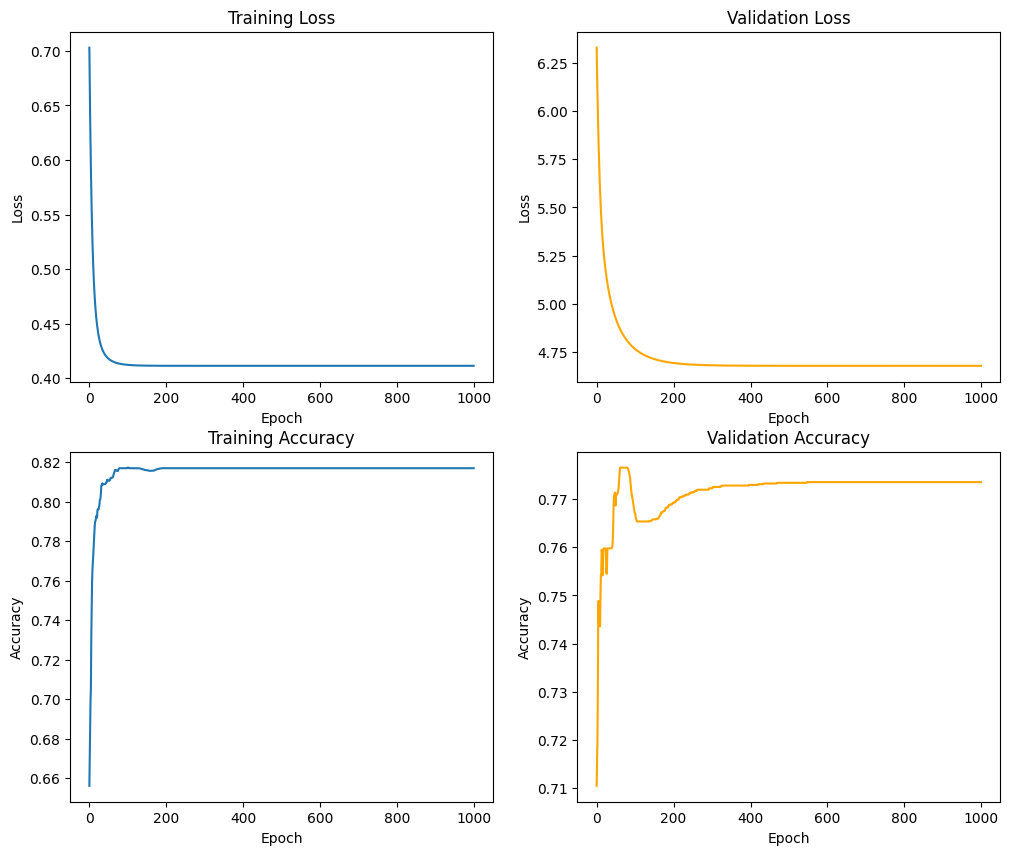

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()


In [24]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)

print("Evaluation on validation test set: ")
print("Validation Accuracy: ", val_set_acc)
print("Test Accuracy: ", test_set_acc)

Evaluation on validation test set: 
Validation Accuracy:  0.776536312849162
Test Accuracy:  0.7865168539325843
